

## ARIMA (AutoRegressive Integrated Moving Average)

* Used to understand data and forecast future values
* It works well when data does not depend on external factors
* Several models (ARIMA, SARIMA, SARIMAX)
* "Integrated" part of the model helps to manage non-stationary data

#### ARIMA(p,d,q)
* AR(p) : Autoregration model that exploits relationship between the current observation and the previous ones over a given period (and a stochastic, not predictable term)
* I(d) : differencing process
* MA(q) : it exploits dependency between the current observation and the residual error from a moving average model applied to q lagged observations

In [2]:
!pip install pmdarima
import pandas as pd
import matplotlib.pyplot as plt
import json
%matplotlib inline

file_p = 'std_Throughput.json'

# Load specific forecasting tools
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
import statsmodels.api
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

tsr = pd.read_json(file_p)

<Axes: >

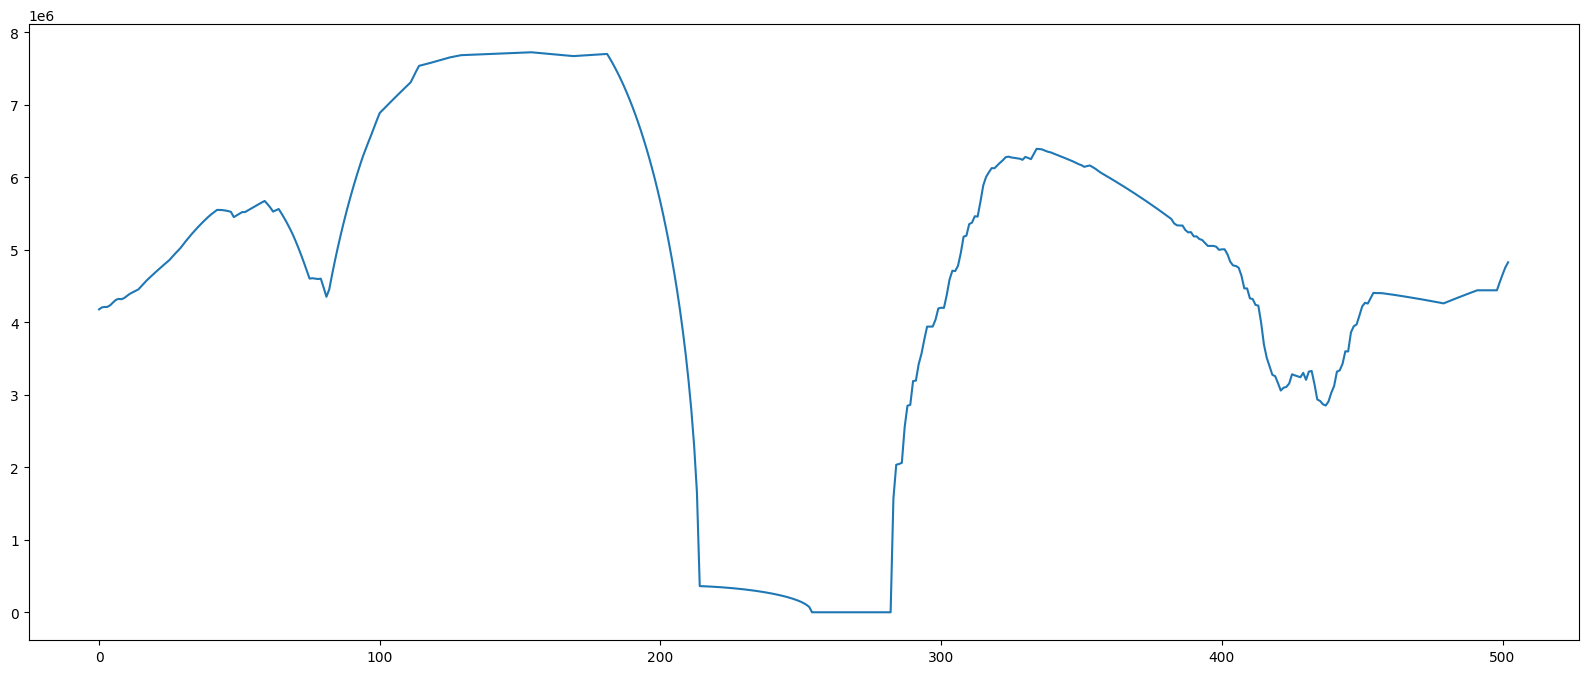

In [3]:
# try to predict trend: Extract trend
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(tsr[1][:], model='additive', period=1)
trend = result.trend.dropna()
trend.plot(figsize=(20,8))

In [4]:
#Check stationarity (p_value < 0.05)
from statsmodels.tsa.stattools import adfuller
adft = adfuller(trend,autolag='AIC')

#print them with info
print('Augmented Dickey-Fuller Test trends')

out = pd.Series(adft[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in adft[4].items():
    out[f'critical value ({key})']=val
print(out)

Augmented Dickey-Fuller Test trends
ADF test statistic       -2.303482
p-value                   0.170847
# lags used               7.000000
# observations          495.000000
critical value (1%)      -3.443630
critical value (5%)      -2.867397
critical value (10%)     -2.569889
dtype: float64


<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

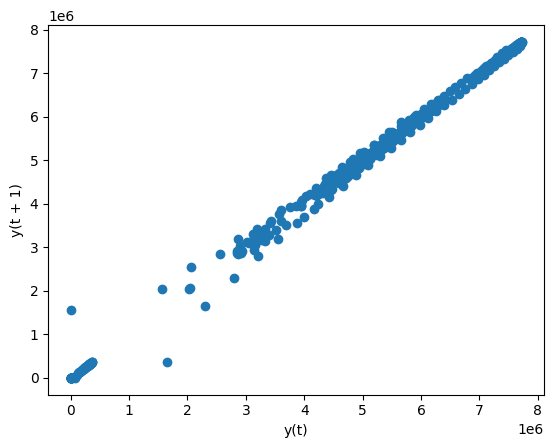

In [5]:
#Lags plot
from pandas.plotting import lag_plot

lag_plot(trend)  #check resid, seasonal

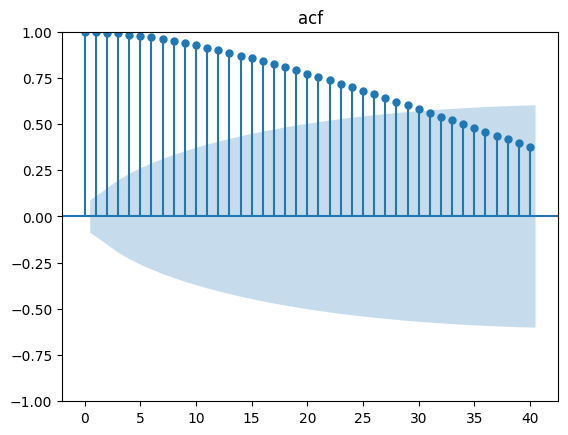

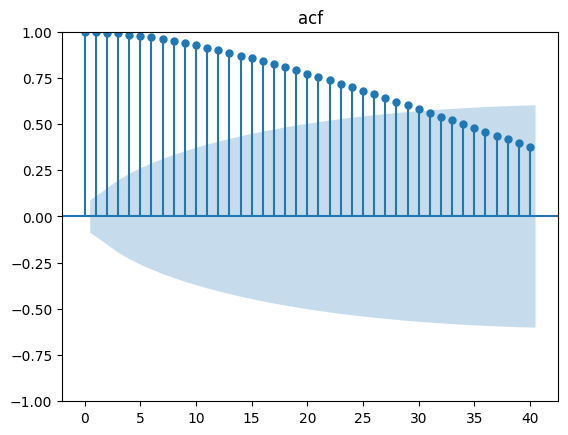

In [6]:
plot_acf(trend,title='acf',lags=40)

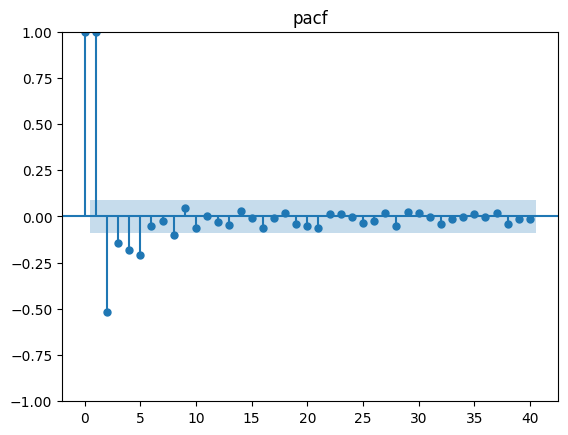

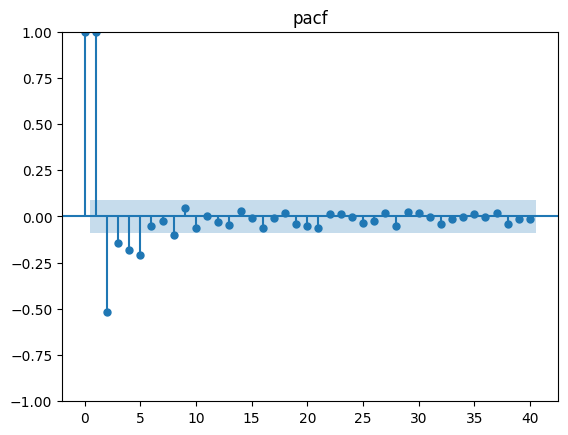

In [7]:
plot_pacf(trend,title='pacf',lags=40)

If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more easily by adding AR terms than by adding MA terms.

In [8]:
auto_arima(trend)
# auto_arima(trend,seasonal=True,m=25)

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [9]:
trend.describe()

count    5.030000e+02
mean     4.714405e+06
std      2.253992e+06
min      0.000000e+00
25%      4.062640e+06
50%      5.022820e+06
75%      6.237205e+06
max      7.722931e+06
Name: trend, dtype: float64

In [10]:
train = trend.iloc[:250]
test = trend.iloc[250:]

In [11]:
model = statsmodels.api.tsa.ARIMA(train, order=(1,1,1))
# model = statsmodels.api.tsa.SARIMAX(train,order=(3,0,0),seasonal_order=(0,0,0,25))

In [12]:
trends = model.fit()

In [13]:
trends.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  trend   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3267.463
Date:                Sun, 28 Jan 2024   AIC                           6540.925
Time:                        21:12:24   BIC                           6551.477
Sample:                             0   HQIC                          6545.173
                                - 250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8884      0.021     42.152      0.000       0.847       0.930
ma.L1         -0.8221      0.026    -31.798      0.000      -0.873      -0.771
sigma2      7.551e+09   5.81e-12    1.3e+21      0.000    7.55e+09    7.55e+09
===================================================================================
Ljung-Box (L1) (Q):                  87.73   Jarque-Bera (JB):             22011.14
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.09   Skew:                            -5.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        47.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.27e+36. Standard errors may be unstable.
"""

In [14]:
start=len(train)
end=len(train)+len(test)-1
predictions = trends.predict(start=start, end=end, dynamic=False, typ='linear')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

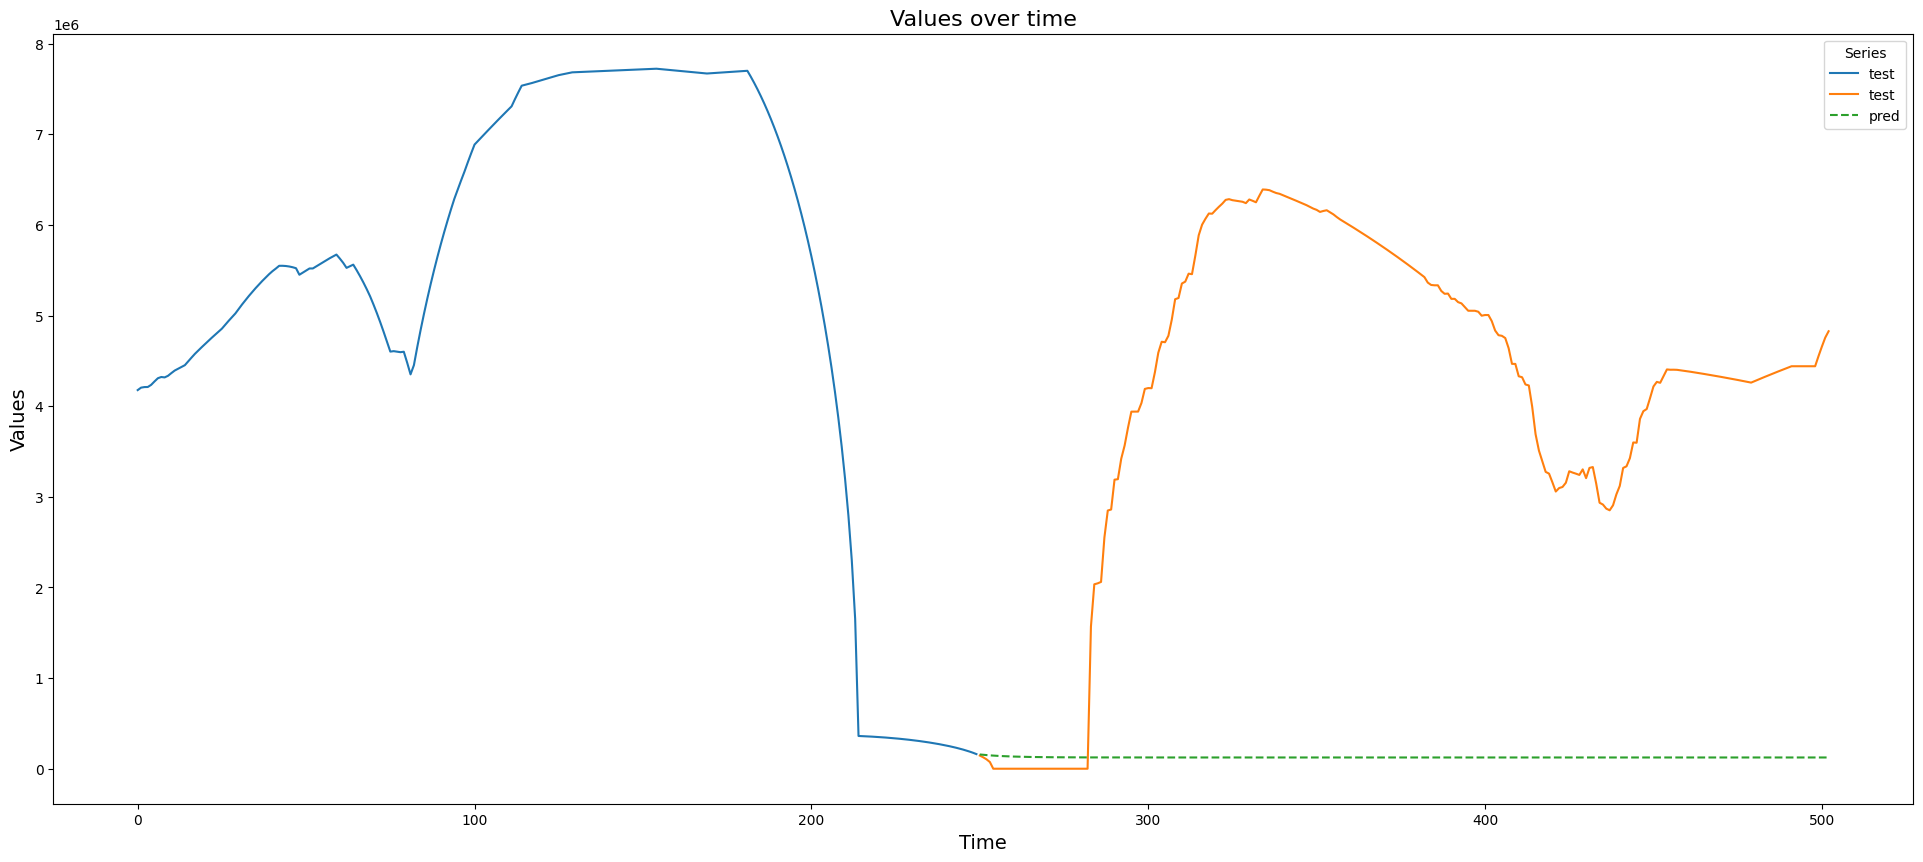

In [15]:
#define size
plt.figure(figsize=(24,10))
#add axes labels and a title
plt.ylabel('Values', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Values over time', fontsize=16)
plt.plot(train,"-", label = 'test')
plt.plot(test,"-", label = 'test')
plt.plot(predictions,"--", label = 'pred')
#add legend
plt.legend(title='Series')

In [16]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions)
error

19606979136157.406

In [17]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test, predictions)
error

4427976.867166021

In [18]:
trend.describe()

count    5.030000e+02
mean     4.714405e+06
std      2.253992e+06
min      0.000000e+00
25%      4.062640e+06
50%      5.022820e+06
75%      6.237205e+06
max      7.722931e+06
Name: trend, dtype: float64

In [19]:
model = statsmodels.api.tsa.ARIMA(trend,order=(3,2,5))
trends = model.fit()
fcast = trends.predict(len(trend),len(trend)+72,typ='linear')

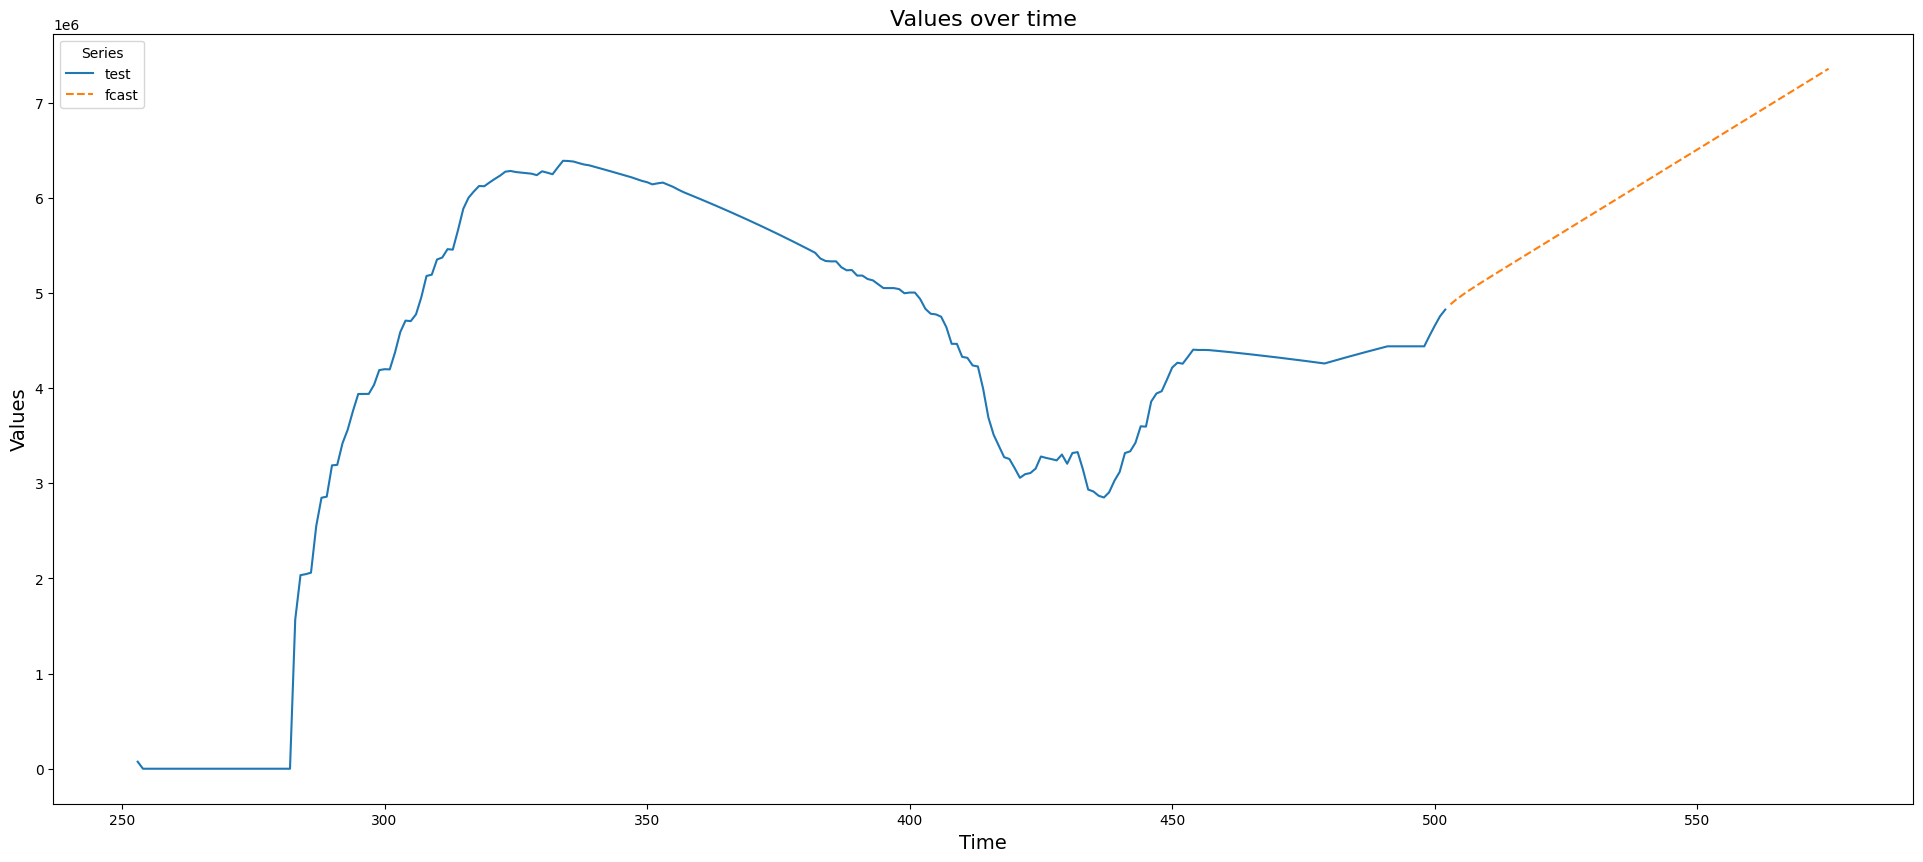

In [20]:
#define size
plt.figure(figsize=(24,10))
#add axes labels and a title
plt.ylabel('Values', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Values over time', fontsize=16)
plt.plot(trend.iloc[-250:],"-", label = 'test')
plt.plot(fcast,"--", label = 'fcast')
#add legend
plt.legend(title='Series')